Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import f_oneway

Python(15087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Get data

In [5]:
dfin

,sample_rate,bit_depth,duration,syllabic_rate,zcr_mean,zcr_std,zcr_frequncy,mean_spectral_envelope,median_spectral_envelope,min_spectral_envelope,...,chroma12_short_1_diff,chroma12_short_1_grad,chroma12_short_2_diff,chroma12_short_2_grad,chroma12_short_3_diff,chroma12_short_3_grad,file_name,language,emotion,gender
0,24414,16,1.447039,0.691067,0.117020,0.136675,0.691067,2666.669454,2059.976084,510.357638,...,0.044739,0.944358,-0.046488,1.061365,-0.643395,6.635859,ENG_ANG_M_(. Toronto-emotional-speech-set-TESS...,ENG,ANG,M
1,24414,16,2.306873,0.433487,0.139085,0.207448,0.433487,2689.862248,1904.080311,345.885895,...,-0.343588,1.680970,0.041982,0.923187,-0.195177,1.555489,ENG_SAD_F_(. Toronto-emotional-speech-set-TESS...,ENG,SAD,F
2,48000,16,2.986667,0.334821,0.100685,0.066329,0.334821,3223.461090,2810.357562,1332.295478,...,-0.229053,1.752473,0.025850,0.921727,0.133701,0.711821,ITA_ANG_M_(. EMOVO Dataset m1 rab-m1-n2.wav).wav,ITA,ANG,M
3,24414,16,2.390759,0.418277,0.098616,0.155018,0.418277,2004.583554,1027.805017,680.436796,...,-0.620428,2.905574,-0.093289,1.401591,0.328197,0.414451,ENG_SAD_M_(. Toronto-emotional-speech-set-TESS...,ENG,SAD,M
4,48000,16,2.442667,0.409389,0.091279,0.046319,0.409389,3051.440749,2908.715697,1906.216930,...,0.191882,0.636938,-0.141712,1.366372,-0.184450,1.911550,ITA_ANG_M_(. EMOVO Dataset m1 rab-m1-n3.wav).wav,ITA,ANG,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,24414,16,2.118129,0.472115,0.140113,0.189476,0.472115,3059.588231,2445.992413,852.602903,...,0.203555,0.400390,-0.123417,1.571211,0.240600,0.473134,ENG_HAP_F_(. Toronto-emotional-speech-set-TESS...,ENG,HAP,F
2550,44100,16,2.623855,0.381119,0.045636,0.060481,0.381119,2596.093815,1574.410869,891.624045,...,-0.226225,1.491328,0.373557,0.552086,-0.035689,1.044706,EST_HAP_F_(. Estonian-Emotional-Speech-Corpus ...,EST,HAP,F
2551,24414,16,2.242320,0.445967,0.075734,0.128618,0.445967,1942.986513,1328.479488,334.430428,...,-0.364930,1.880105,0.141560,0.745489,-0.014901,1.027528,ENG_SAD_M_(. Toronto-emotional-speech-set-TESS...,ENG,SAD,M
2552,16000,16,1.504000,0.664894,0.100830,0.088743,0.664894,1661.715440,1429.481988,392.613331,...,0.732691,0.242322,-0.301457,1.452935,-0.388936,2.405992,GER_HAP_F_(. emo-db dataset wav 08a02Fe.wav).wav,GER,HAP,F


In [4]:
filename = '../data/full_df.csv'

dfin = pd.read_csv(filename)
droplist= ['file_name', 'gender', 'sample_rate', 'bit_depth'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df = dfin.drop(droplist, axis=1)

#store the language labels separately
langdata = df[['language']]
df = pd.get_dummies(df, columns=['language'])

#remove categorical columns except the column of interest, one gender

#separate out the known labels from the predictors
labcol = ['emotion']
labels = df[labcol]
features = df.drop(labcol, axis=1)

print(labels)
print(features)


KeyError: "['gender'] not found in axis"

## Center and Scale

In [30]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


array([[-0.88515553,  1.38490949, -0.0285825 , ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.21070477, -0.14328128,  0.43763899, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [ 0.33950506, -0.73331395,  1.53104189, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154],
       [-0.15745866, -0.21590352, -0.40345375, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.08646384, -0.30639854,  1.21061747, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154]])

# K-means clustering

In [31]:
#make modeling
kmeans = KMeans(
    init="random", #initialization technique
    n_clusters=3, # num of clusters
    n_init=10, #of starts to run
    max_iter=300, # num of iterations for each start
)

#make model for our input
kmeans.fit(scaled_features)

#results of the clustering:
print("The lowest SSE value", kmeans.inertia_)
print("Final locations of the centroid", kmeans.cluster_centers_)
print("The number of iterations required to converge", kmeans.n_iter_)
#some cluster results:
kmeans.labels_[:5]

The lowest SSE value 1400890.5072339003
Final locations of the centroid [[-0.45051554  0.41216521 -0.286226   ... -0.3382104  -0.4083423
  -0.28515389]
 [-0.49389444  0.36698992  1.46226322 ... -0.33025158 -0.39453908
  -0.29825627]
 [ 0.44248502 -0.37775151 -0.28535087 ...  0.31925647  0.38412034
   0.27549263]]
The number of iterations required to converge 5


array([0, 0, 2, 0, 2], dtype=int32)

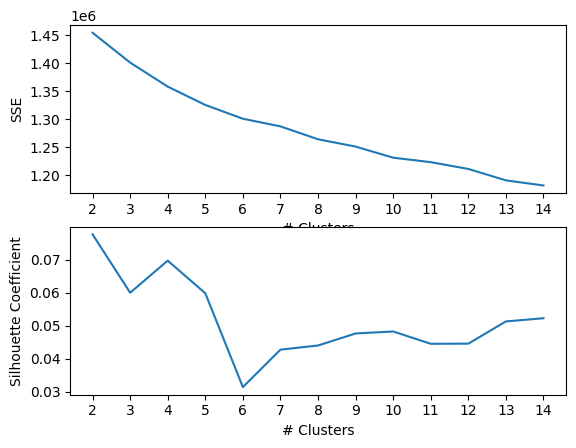

In [32]:
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coeffs.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [33]:
#find elbow mathematically:
kl = KneeLocator(
    range(2, tryks), sse, curve="convex", direction="decreasing"
)

kelbow = kl.elbow
print(kelbow)


8


In [34]:
#find max cluster number mathematically
maxsc = max(silhouette_coeffs)
katmaxsc = silhouette_coeffs.index(maxsc)+2
print(katmaxsc)

2


Do these clusters correspond with any emotions?

In [35]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

labels['elbow'] = elbowclusters
labels['silhouette'] = silclusters
print(labels)

     emotion  elbow  silhouette
0        ANG      7           1
1        SAD      4           1
2        ANG      1           0
3        SAD      0           1
4        ANG      1           0
...      ...    ...         ...
2528     HAP      2           1
2529     HAP      6           0
2530     SAD      0           1
2531     HAP      6           0
2532     HAP      2           1

[2533 rows x 3 columns]


/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_18701/2770014292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow'] = elbowclusters
/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_18701/2770014292.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette'] = silclusters


In [36]:
#now compare
emottotals = labels.groupby('emotion').size().reset_index(name='emottotals')

grouped0 = labels.groupby(['emotion', 'elbow']).size().reset_index(name='count')
grouped1 = labels.groupby(['emotion', 'silhouette']).size().reset_index(name='count')

merged0 = pd.merge(grouped0, emottotals, on='emotion')
merged0['percentage'] = (merged0['count'] / merged0['emottotals']) * 100

merged1 = pd.merge(grouped1, emottotals, on='emotion')
merged1['percentage'] = (merged1['count'] / merged1['emottotals']) * 100

print(merged1)

  emotion  silhouette  count  emottotals  percentage
0     ANG           0    482         887   54.340474
1     ANG           1    405         887   45.659526
2     HAP           0    418         832   50.240385
3     HAP           1    414         832   49.759615
4     SAD           0    405         814   49.754300
5     SAD           1    409         814   50.245700


With 2 groups, there is no differentiation between the emotions

In [37]:
print(merged0)

   emotion  elbow  count  emottotals  percentage
0      ANG      0      1         887    0.112740
1      ANG      1    314         887   35.400225
2      ANG      2    198         887   22.322435
3      ANG      3     90         887   10.146561
4      ANG      4      1         887    0.112740
5      ANG      5      7         887    0.789177
6      ANG      6     72         887    8.117249
7      ANG      7    204         887   22.998873
8      HAP      0    201         832   24.158654
9      HAP      1    200         832   24.038462
10     HAP      2    202         832   24.278846
11     HAP      3    107         832   12.860577
12     HAP      5      9         832    1.081731
13     HAP      6    110         832   13.221154
14     HAP      7      3         832    0.360577
15     SAD      0    201         814   24.692875
16     SAD      1     43         814    5.282555
17     SAD      2      1         814    0.122850
18     SAD      3    227         814   27.886978
19     SAD      4   

With more groups, there is some differentiation. Let's get a better look.

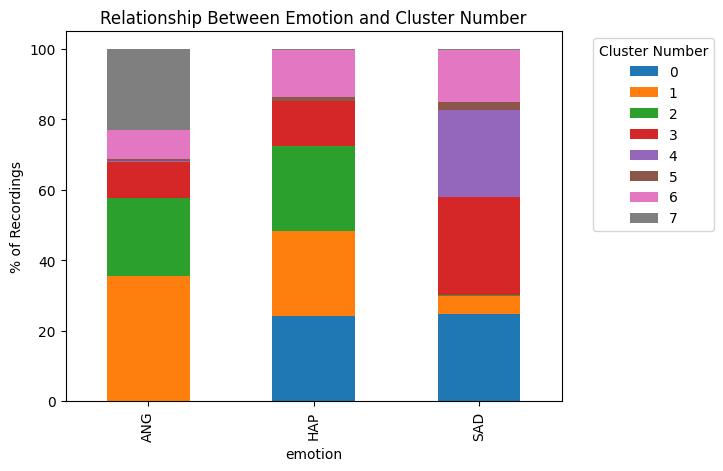

In [38]:
merged0['count'] = merged0['count'].astype(int) #avoid float error
merged0['elbow'] = merged0['elbow'].astype(str) #avoid float error

plotdf = merged0.pivot(index='emotion', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Do these clusters correspond with any languages?

In [39]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

langdata['elbow'] = elbowclusters
langdata['silhouette'] = silclusters
print(langdata)

     language  elbow  silhouette
0         ENG      2           1
1         ENG      5           1
2         ITA      7           0
3         ENG      1           1
4         ITA      7           0
...       ...    ...         ...
2528      ENG      4           1
2529      EST      0           0
2530      ENG      1           1
2531      GER      3           0
2532      ENG      4           1

[2533 rows x 3 columns]


In [40]:
#now compare
langtotals = langdata.groupby('language').size().reset_index(name='langtotals')

groupedl0 = langdata.groupby(['language', 'elbow']).size().reset_index(name='count')
groupedl1 = langdata.groupby(['language', 'silhouette']).size().reset_index(name='count')

mergedl0 = pd.merge(groupedl0, langtotals, on='language')
mergedl0['percentage'] = (mergedl0['count'] / mergedl0['langtotals']) * 100

mergedl1 = pd.merge(groupedl1, langtotals, on='language')
mergedl1['percentage'] = (mergedl1['count'] / mergedl1['langtotals']) * 100

print(mergedl1)

  language  silhouette  count  langtotals  percentage
0      ENG           1   1199        1199  100.000000
1      EST           0    380         386   98.445596
2      EST           1      6         386    1.554404
3      FRE           0     94         108   87.037037
4      FRE           1     14         108   12.962963
5      GER           0    259         260   99.615385
6      GER           1      1         260    0.384615
7      GRE           0    362         362  100.000000
8      ITA           0    210         218   96.330275
9      ITA           1      8         218    3.669725


With 2 clusters, there does seem to be a difference between the languages.

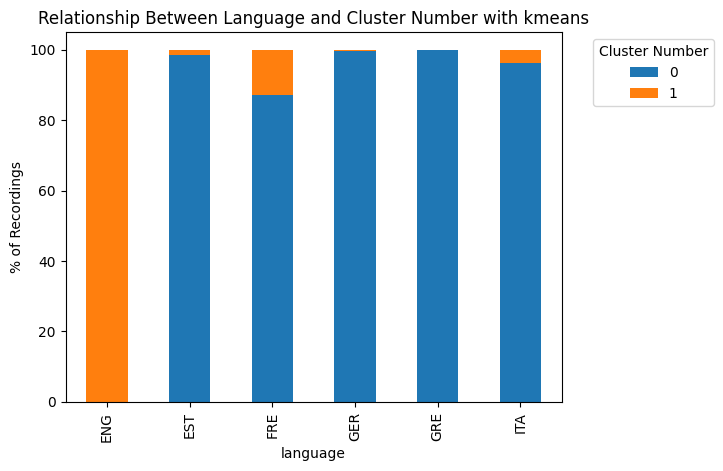

In [41]:
mergedl1['count'] = mergedl1['count'].astype(int) #avoid float error
mergedl1['silhoutte'] = mergedl1['silhouette'].astype(str) #avoid float error

plotdf = mergedl1.pivot(index='language', columns='silhouette', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number with kmeans')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [42]:
print(mergedl0)

   language  elbow  count  langtotals  percentage
0       ENG      1    401        1199   33.444537
1       ENG      2    199        1199   16.597164
2       ENG      4    195        1199   16.263553
3       ENG      5    200        1199   16.680567
4       ENG      6    204        1199   17.014178
5       EST      0    252         386   65.284974
6       EST      1      1         386    0.259067
7       EST      3    132         386   34.196891
8       EST      7      1         386    0.259067
9       FRE      1      2         108    1.851852
10      FRE      2      1         108    0.925926
11      FRE      3     14         108   12.962963
12      FRE      5      1         108    0.925926
13      FRE      6      2         108    1.851852
14      FRE      7     88         108   81.481481
15      GER      0     71         260   27.307692
16      GER      2      2         260    0.769231
17      GER      3      5         260    1.923077
18      GER      6      1         260    0.384615


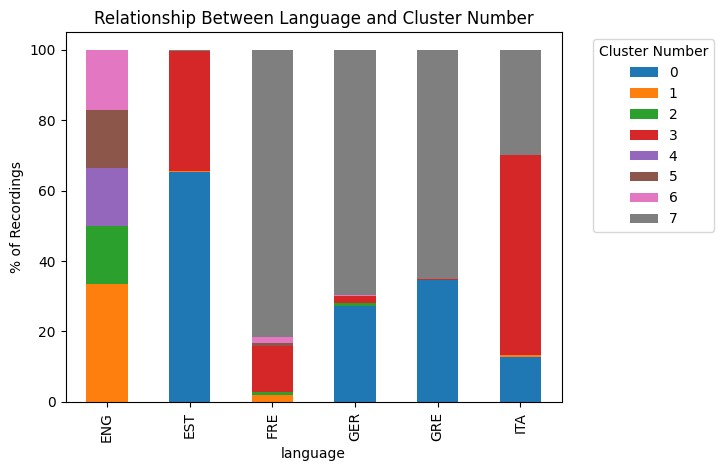

In [43]:
mergedl0['count'] = mergedl0['count'].astype(int) #avoid float error
mergedl0['elbow'] = mergedl0['elbow'].astype(str) #avoid float error

plotdf = mergedl0.pivot(index='language', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

There is a clear separation between languages. Honestly, since there is a column for each lanuage one-hot encoded, it actually has everything it needs to separate them out nicely. What happens if we redo this, but remove that information?

# Without Language Data

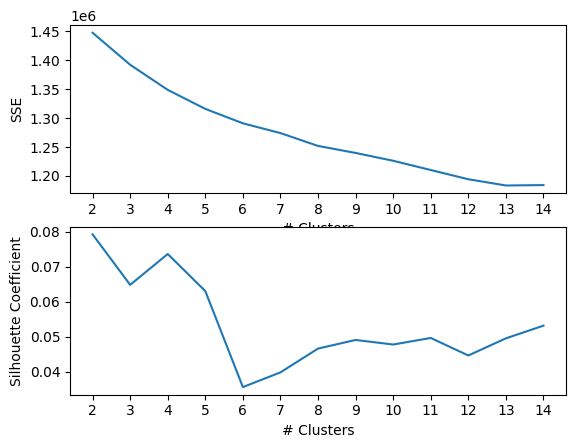

In [70]:
df2 = pd.get_dummies(dfin, columns=['gender'])
#drop the empty column at the beginning
df2 = df2.drop('Unnamed: 0',axis = 1)

#remove categorical columns except the column of interest, one gender. Remove language.
droplist= ['file_name', 'gender_M', 'sample_rate', 'bit_depth', 'language'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df2 = df2.drop(droplist, axis=1)
features2 = df2.drop(labcol, axis=1)
#Center and Scale
scaled_features2 = scaler.fit_transform(features2)

#make model for our input
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse2 = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs2 = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features2)
    sse2.append(kmeans.inertia_)
    score = silhouette_score(scaled_features2, kmeans.labels_)
    silhouette_coeffs2.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()



In [71]:
#find elbow mathematically:
kl2 = KneeLocator(
    range(2, tryks), sse2, curve="convex", direction="decreasing"
)
kelbow2 = kl2.elbow

#find max cluster number mathematically
maxsc2 = max(silhouette_coeffs2)
katmaxsc2 = silhouette_coeffs2.index(maxsc2)+2

Look for correlations with emotions

In [72]:
#Run with k from elbow method:
kmeanselbow2 = KMeans(n_clusters=kelbow2, **kmeans_kwargs)
elbowclusters2 = kmeanselbow2.fit_predict(scaled_features2)
#Run with k from silhouette coeffs method:
kmeanssil2 = KMeans(n_clusters=katmaxsc2, **kmeans_kwargs)
silclusters2 = kmeanssil2.fit_predict(scaled_features2)

labels['elbow2'] = elbowclusters2
labels['silhouette2'] = silclusters2
print(labels)

     emotion  elbow  silhouette  elbow2  silhouette2
0        ANG      7           1       4            0
1        SAD      4           1       6            0
2        ANG      1           0       7            1
3        SAD      0           1       0            0
4        ANG      1           0       7            1
...      ...    ...         ...     ...          ...
2528     HAP      2           1       3            0
2529     HAP      6           0       2            1
2530     SAD      0           1       0            0
2531     HAP      6           0       2            1
2532     HAP      2           1       3            0

[2533 rows x 5 columns]


/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_18701/1174464912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow2'] = elbowclusters2
/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_18701/1174464912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette2'] = silclusters2


In [73]:
grouped02 = labels.groupby(['emotion', 'elbow2']).size().reset_index(name='count')
grouped12 = labels.groupby(['emotion', 'silhouette2']).size().reset_index(name='count')

merged02 = pd.merge(grouped02, emottotals, on='emotion')
merged02['percentage2'] = (merged02['count'] / merged02['emottotals']) * 100

merged12 = pd.merge(grouped12, emottotals, on='emotion')
merged12['percentage'] = (merged12['count'] / merged12['emottotals']) * 100

print(merged12)
print(merged02)

  emotion  silhouette2  count  emottotals  percentage
0     ANG            0    406         887   45.772266
1     ANG            1    481         887   54.227734
2     HAP            0    417         832   50.120192
3     HAP            1    415         832   49.879808
4     SAD            0    412         814   50.614251
5     SAD            1    402         814   49.385749
   emotion  elbow2  count  emottotals  percentage2
0      ANG       0      2         887     0.225479
1      ANG       1    199         887    22.435175
2      ANG       2    154         887    17.361894
3      ANG       4    209         887    23.562570
4      ANG       5      1         887     0.112740
5      ANG       7    322         887    36.302142
6      HAP       0      4         832     0.480769
7      HAP       1      5         832     0.600962
8      HAP       2    199         832    23.918269
9      HAP       3    196         832    23.557692
10     HAP       4     10         832     1.201923
11     HAP

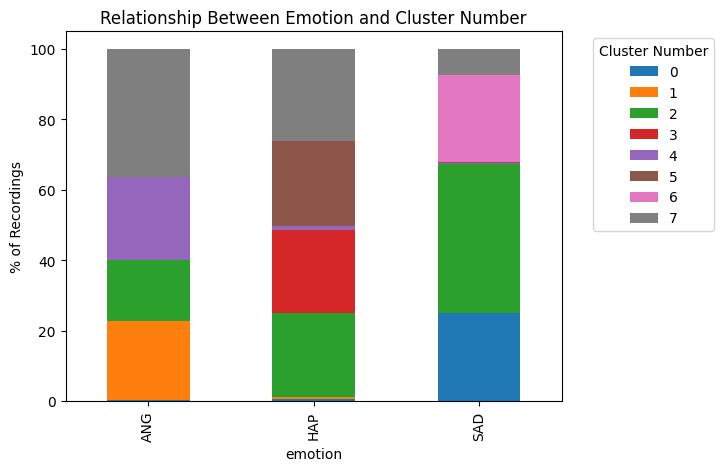

In [74]:
merged02['count'] = merged02['count'].astype(int) #avoid float error
merged02['elbow2'] = merged02['elbow2'].astype(str) #avoid float error

plotdf2 = merged02.pivot(index='emotion', columns='elbow2', values='percentage2').fillna(0)

plotdf2.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Find important features

In [75]:
#Add the cluster number to the original data
features2['kcluster'] = elbowclusters2
# Calculate centroids
centroids = features2.groupby('kcluster').mean()
print(centroids)


          duration  syllabic_rate  zcr_mean   zcr_std  zcr_frequncy  \
kcluster                                                              
0         2.479791       0.406422  0.092395  0.140253      0.406422   
1         2.041875       0.492977  0.211699  0.229183      0.492977   
2         3.497028       0.377023  0.084160  0.081954      0.372462   
3         1.829130       0.549493  0.190787  0.226436      0.549493   
4         1.425849       0.729798  0.099390  0.099908      0.729798   
5         1.964952       0.512113  0.116837  0.157983      0.512113   
6         2.155693       0.466125  0.139610  0.217500      0.466125   
7         2.830697       0.395936  0.144266  0.114093      0.395936   

          mean_spectral_envelope  median_spectral_envelope  \
kcluster                                                     
0                    1936.187553               1287.653219   
1                    3395.649049               2716.516161   
2                    1834.319249         

In [76]:
#Use ANOVA to find the important features
anova_results = {}
for feature in features2.columns[:-1]:  # exclude the 'Cluster' column
    groups = [features2[features2['kcluster'] == cluster][feature] for cluster in features2['kcluster'].unique()]
    anova_results[feature] = f_oneway(*groups)

#We have so many tests. Do a Bonferroni correction
num_tests = len(anova_results)
p_values = [anova_results[feature].pvalue for feature in anova_results]
corrected_p_values = np.minimum(np.array(p_values) * num_tests, 1.0)  # Bonferroni correction


# Display the results
anova_results_df = pd.DataFrame(anova_results, index=['F-Statistic', 'P-Value']).T
anova_results_df['Bonf Ps'] = corrected_p_values
print(anova_results_df.sort_values(by='Bonf Ps'))

/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_18701/74000813.py:5: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  anova_results[feature] = f_oneway(*groups)


                                     F-Statistic  P-Value  Bonf Ps
gender_F                              347.746606      0.0      0.0
mfccs_std_3                           525.588817      0.0      0.0
meancent                              508.015215      0.0      0.0
minf_items_short_2                    310.271410      0.0      0.0
mfccs_std_6                           317.739962      0.0      0.0
...                                          ...      ...      ...
frequncys_zcr_diff                           NaN      NaN      NaN
zcr_frequncys_diffs_from_average0_1          NaN      NaN      NaN
zcr_frequncys_diffs_from_average1_2          NaN      NaN      NaN
zcr_frequncys_diffs_from_average2_3          NaN      NaN      NaN
zcr_frequncys_diffs_from_average3_4          NaN      NaN      NaN

[623 rows x 3 columns]


In [77]:
anova_results_df.sort_values(by='Bonf Ps')[480:500]

,F-Statistic,P-Value,Bonf Ps
syllabic_rate_diffs_from_average0_1,9.696531,5.829248e-12,3.631622e-09
magmax_short_3_diff,9.571586,8.655651e-12,5.392470e-09
bw_short_3_grad,9.503974,1.071912e-11,6.678009e-09
bw_short_3_diff,9.313706,1.955676e-11,1.218386e-08
maxptf_short_3_grad,8.656167,1.554123e-10,9.682187e-08
cliprangef0_short_4,8.493385,2.592603e-10,1.615192e-07
chroma05_3_grad,8.272773,5.182246e-10,3.228539e-07
maxf_items_short/maxf_items_short_2,8.240943,5.726281e-10,3.567473e-07
maxpf_short_2_diff,8.168145,7.194294e-10,4.482045e-07
min_amp_short_3_grad,8.072877,9.696297e-10,6.040793e-07


Even with the Bonferroni adjustment and setting a low threshold, there are still a lot of "statistically significant" features between the groups.
Let's just look at the top 20 to get an idea of what is likely to be important.

In [78]:
anova_results_df.sort_values(by='Bonf Ps')[0:20]

,F-Statistic,P-Value,Bonf Ps
gender_F,347.746606,0.0,0.0
mfccs_std_3,525.588817,0.0,0.0
meancent,508.015215,0.0,0.0
minf_items_short_2,310.271410,0.0,0.0
mfccs_std_6,317.739962,0.0,0.0
mfccs_std_7,810.503249,0.0,0.0
meancent_short_2,411.596300,0.0,0.0
minf_items,316.912612,0.0,0.0
min_amp,370.174829,0.0,0.0
mfccs_std_11,641.145047,0.0,0.0


In [79]:
collist = anova_results_df.sort_values(by='Bonf Ps')[0:20].index[1:20].tolist() #gender is categorical

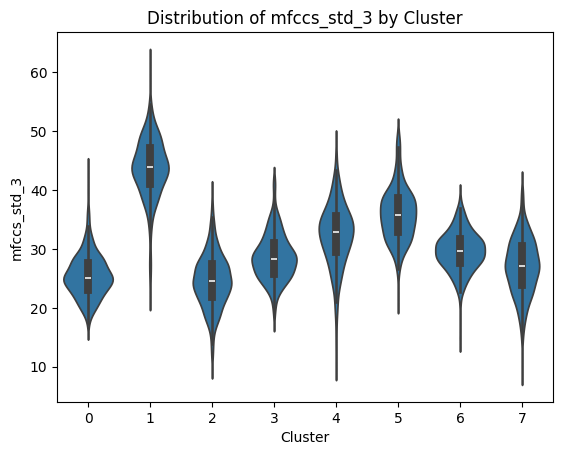

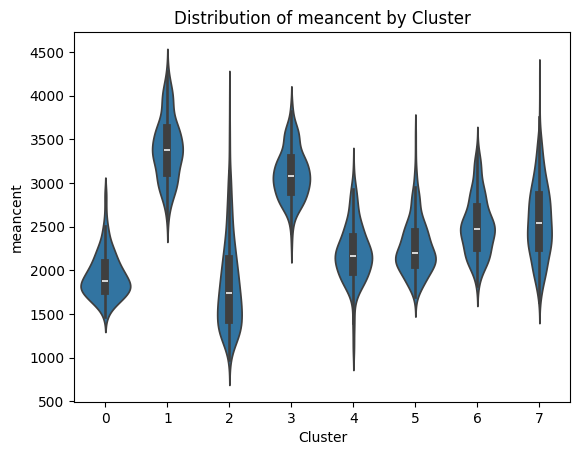

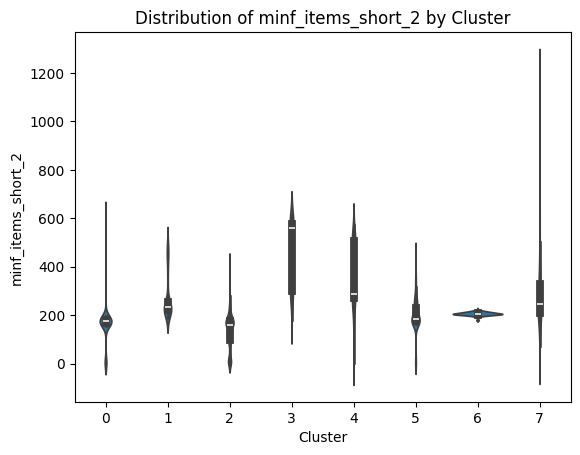

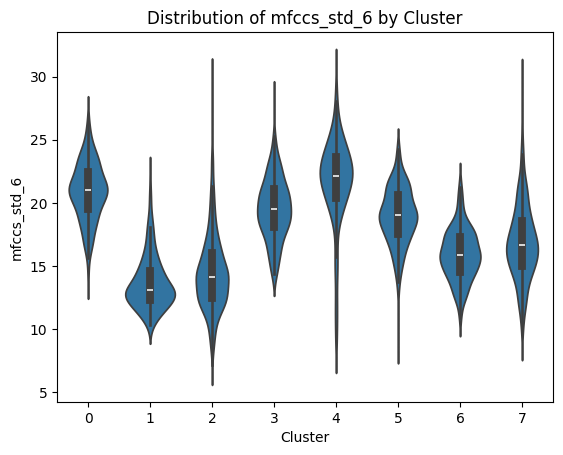

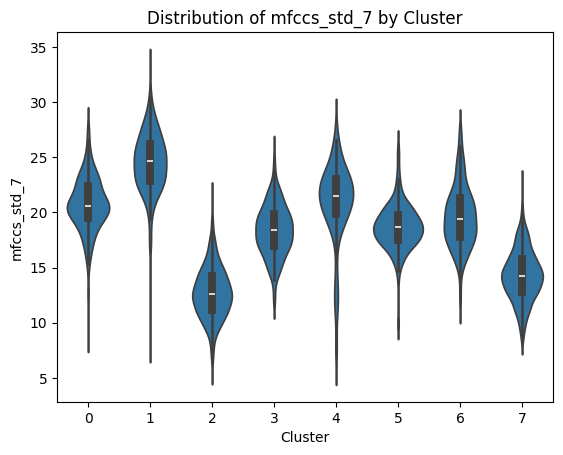

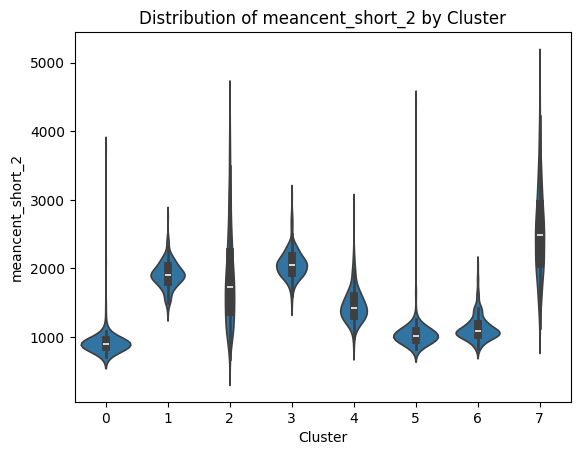

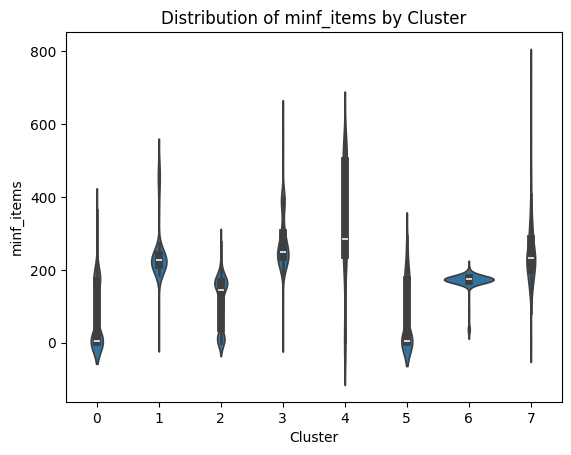

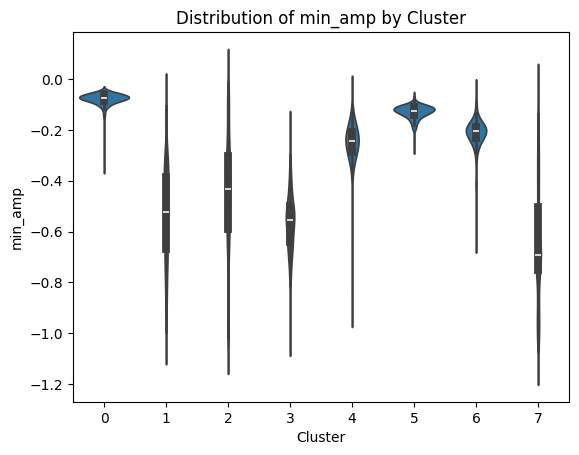

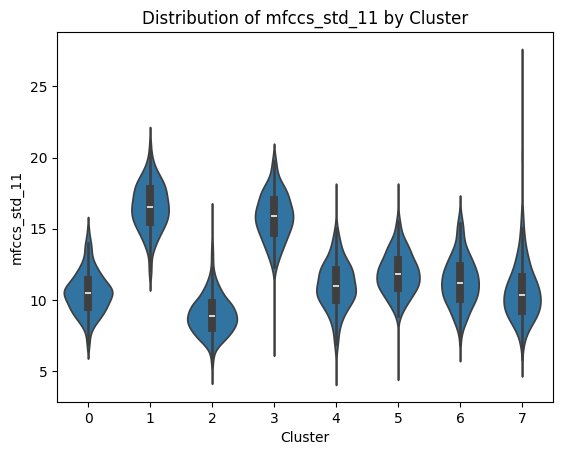

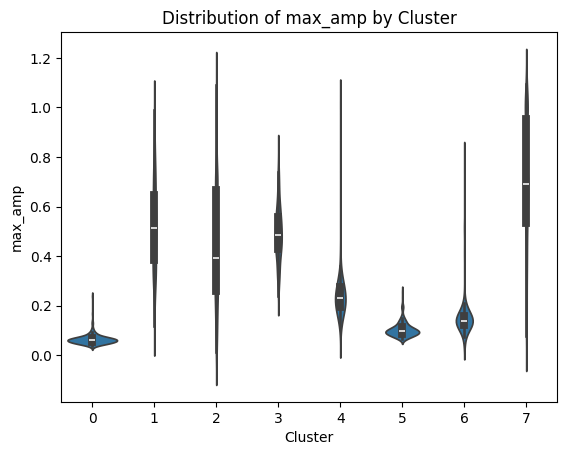

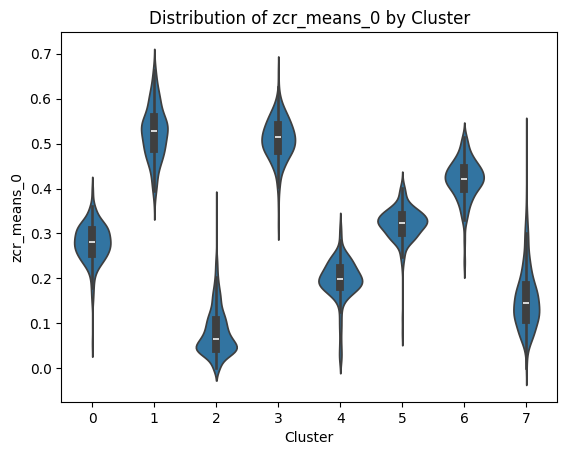

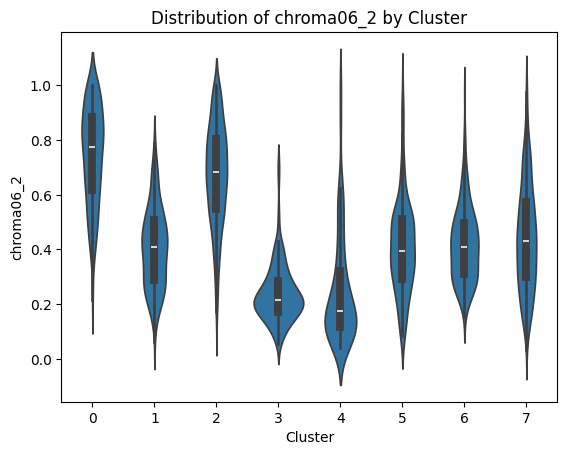

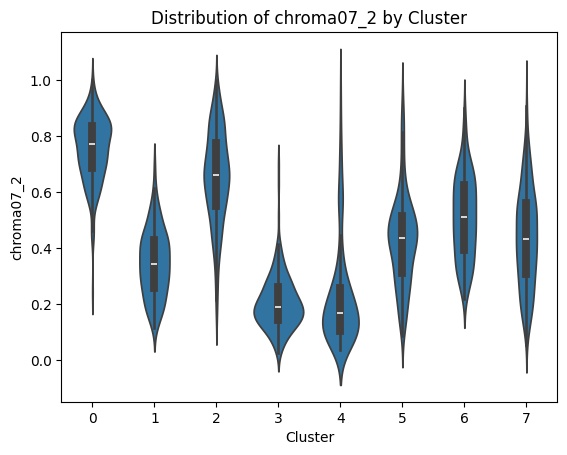

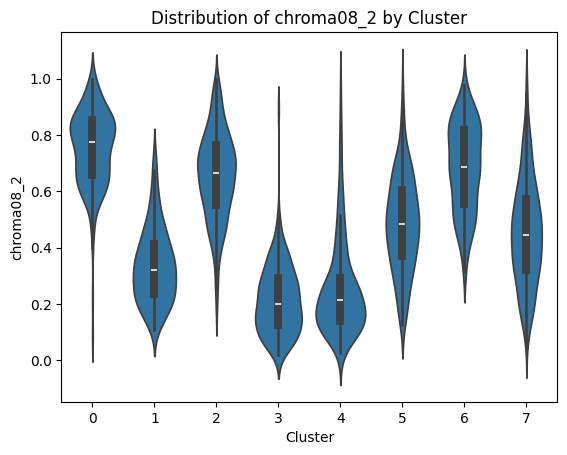

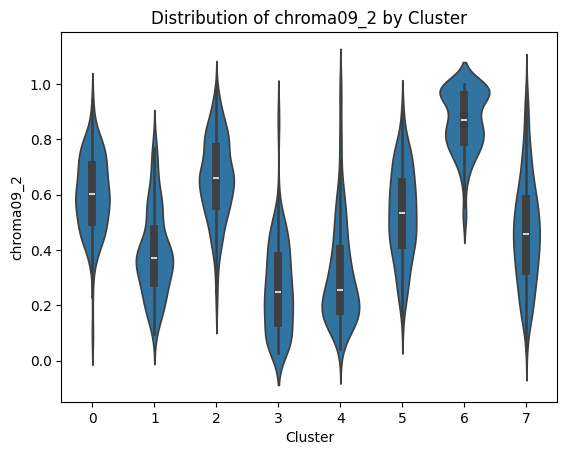

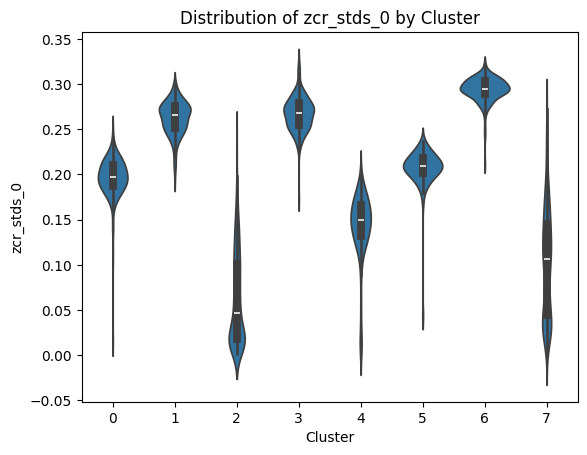

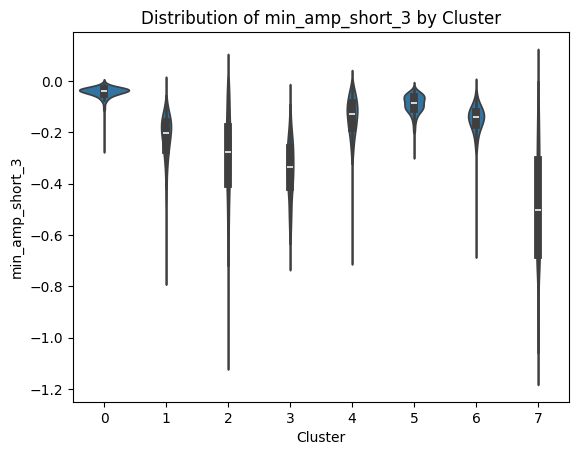

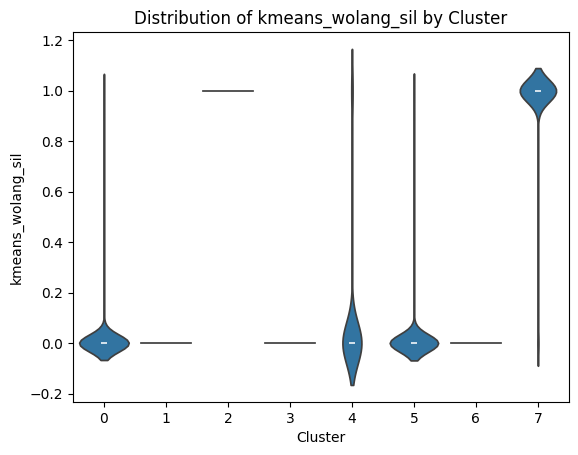

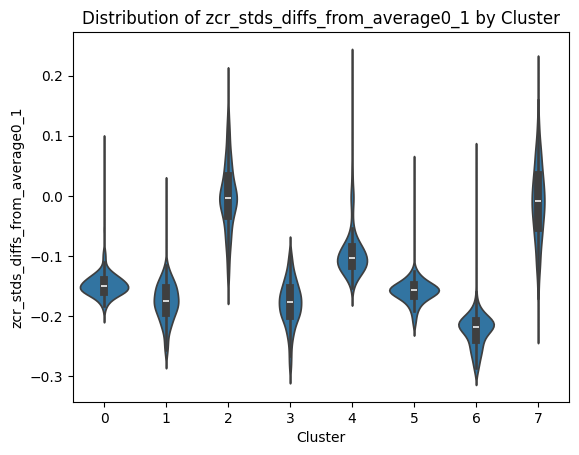

In [80]:
for column in collist:
    #plt.figure(figsize=(10, 6))
    sns.violinplot(x='kcluster', y=column, data=features2)
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

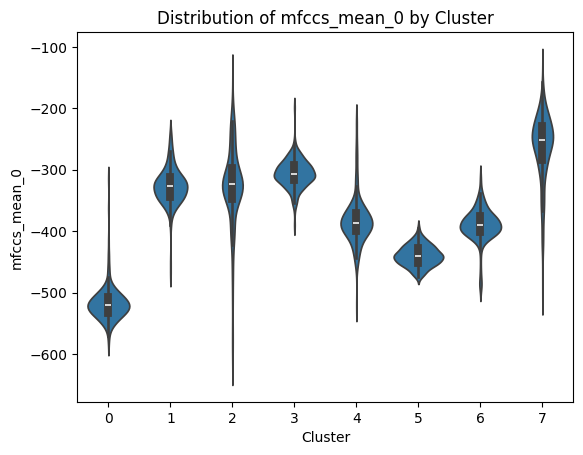

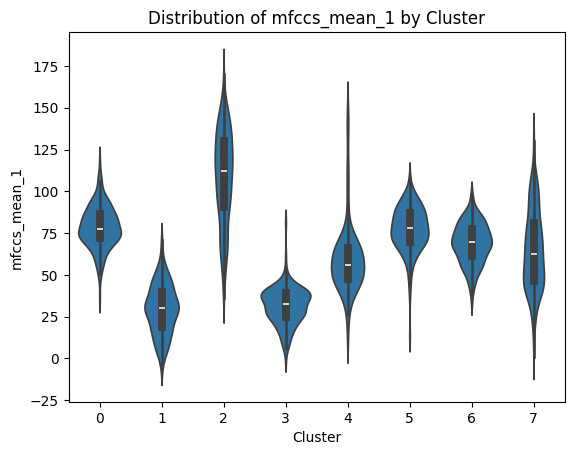

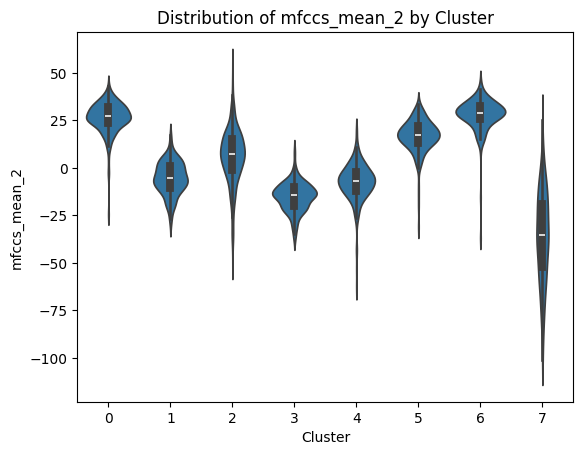

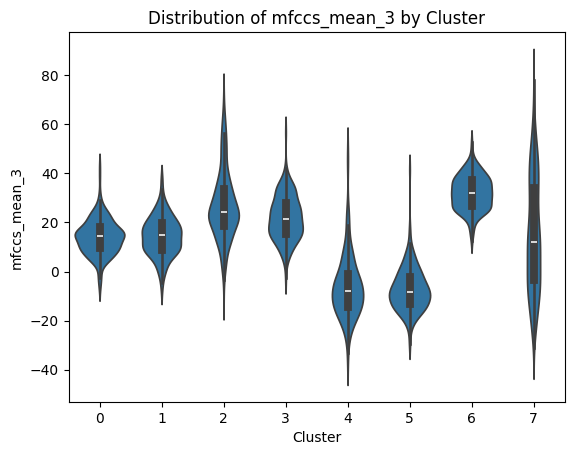

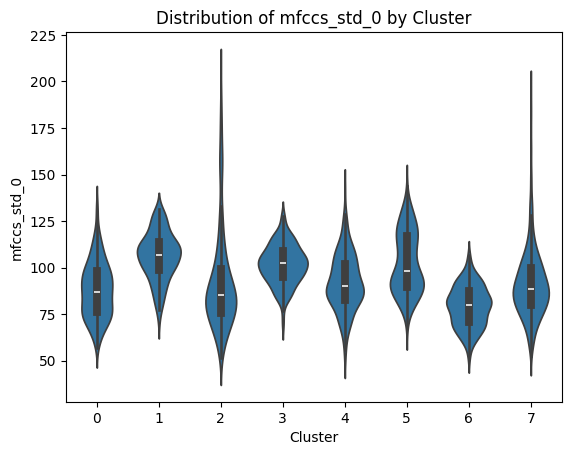

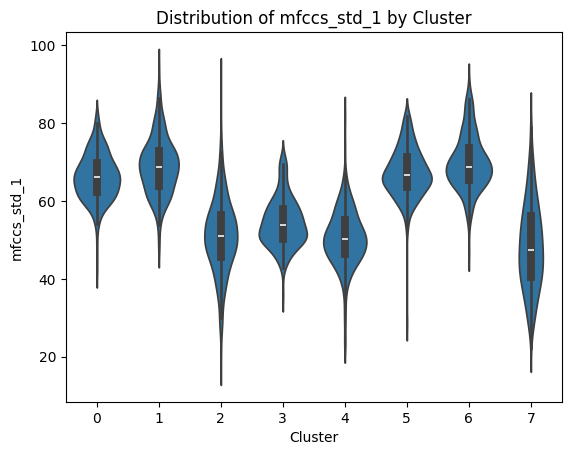

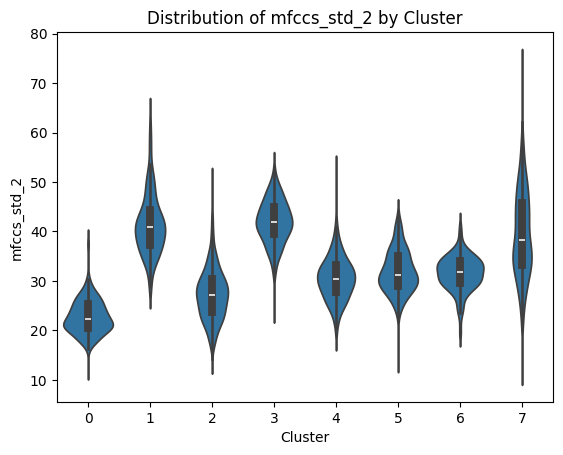

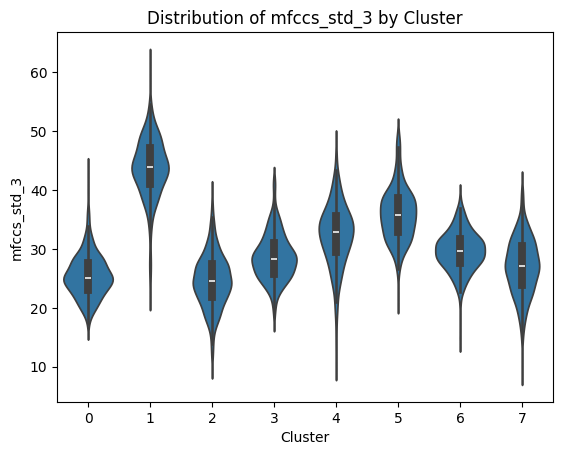

In [81]:
for column in ['mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2', 'mfccs_std_3']:
    #plt.figure(figsize=(10, 6))
    sns.violinplot(x='kcluster', y=column, data=features2)
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

In [82]:
#create and output based on the original data set, but with various clustering information added.

dfout = dfin
dfout['kmeans_wlang_elbow'] = elbowclusters
dfout['kmeans_wolang_elbow'] = elbowclusters2
dfout['kmeans_wlang_sil'] = silclusters
dfout['kmeans_wolang_sil'] = silclusters2

dfout.head()

,Unnamed: 0,sample_rate,bit_depth,duration,syllabic_rate,zcr_mean,zcr_std,zcr_frequncy,mean_spectral_envelope,median_spectral_envelope,...,chroma12_3_diff,chroma12_3_grad,file_name,language,emotion,gender,kmeans_wlang_elbow,kmeans_wolang_elbow,kmeans_wlang_sil,kmeans_wolang_sil
0,0,22050,16,1.439637,0.694619,0.124574,0.139607,0.694619,2473.625757,1921.640692,...,0.661701,7.791005,ENG_ANG_M_(. Toronto-emotional-speech-set-TESS...,ENG,ANG,M,2,4,1,0
1,0,22050,16,2.321995,0.430664,0.148597,0.217951,0.430664,2522.187384,1736.391260,...,0.119791,1.266005,ENG_SAD_F_(. Toronto-emotional-speech-set-TESS...,ENG,SAD,F,5,6,1,0
2,0,22050,16,3.041814,0.328751,0.204938,0.114941,0.328751,3089.715581,2730.327215,...,-0.582636,0.143456,ITA_ANG_M_(. EMOVO Dataset m1 rab-m1-n2.wav).wav,ITA,ANG,M,7,7,0,1
3,0,22050,16,2.391655,0.418120,0.105257,0.164129,0.418120,1866.819458,938.745038,...,-0.269884,0.499443,ENG_SAD_M_(. Toronto-emotional-speech-set-TESS...,ENG,SAD,M,1,0,1,0
4,0,22050,16,2.484535,0.402490,0.188427,0.075686,0.402490,2904.748432,2826.918473,...,0.111024,1.376152,ITA_ANG_M_(. EMOVO Dataset m1 rab-m1-n3.wav).wav,ITA,ANG,M,7,7,0,1
